In [1]:
import os
import itertools
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from resnet import (
    build_transfer_model,
    train_model,
    fine_tune_model,
    plot_training_history,
    plot_confusion_matrix,
    PROCESSED_DIR,
    IMG_HEIGHT,
    IMG_WIDTH,
    NUM_CHANNELS,
)
import data_pipeline as pipeline

In [2]:
BATCH_SIZE = 32  # smaller batch size for transfer learning
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# get image paths, mean and std
train_dir = os.path.join(PROCESSED_DIR, "train")
val_dir = os.path.join(PROCESSED_DIR, "val")
test_dir = os.path.join(PROCESSED_DIR, "test")

all_paths = pipeline.get_image_paths(PROCESSED_DIR)
train_paths = [path for path in all_paths if "/train/" in path]
mean, std = pipeline.calc_mean_std(train_paths)

In [4]:
print("loading train/val/test generators from data_pipeline")
train_data_gen, val_data_gen, test_data_gen, test_data_gen_raw = pipeline.load_data(
    train_dir, val_dir, test_dir, mean, std
)

loading train/val/test generators from data_pipeline
creating train generator
Found 1600 images belonging to 2 classes.
creating validation generator
Found 400 images belonging to 2 classes.
creating test generator (normalized)
Found 200 images belonging to 2 classes.
creating test generator (raw)
Found 200 images belonging to 2 classes.


In [5]:
# get class names
class_names = list(train_data_gen.class_indices.keys())
print(f"class names found: {class_names}")

class names found: ['COVID', 'NORMAL']


In [6]:
# build and train initial model
input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
model = build_transfer_model(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,745,473 (94.40 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 23,564,800 (89.89 MB)


training initial model


/opt/anaconda3/envs/ml-2025/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5746 - loss: 1.8392 - precision: 0.5420 - recall: 0.5806 - val_accuracy: 0.6575 - val_loss: 0.6266 - val_precision: 0.7405 - val_recall: 0.4850
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7120 - loss: 0.6339 - precision: 0.7419 - recall: 0.6422 - val_accuracy: 0.5425 - val_loss: 0.6876 - val_precision: 0.6667 - val_recall: 0.1700
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7535 - loss: 0.4982 - precision: 0.7486 - recall: 0.7616 - val_accuracy: 0.6900 - val_loss: 0.6094 - val_precision: 0.7209 - val_recall: 0.6200
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7889 - loss: 0.4372 - precision: 0.7774 - recall: 0.8030 - val_accuracy: 0.6850 - val_loss: 0.6024 - val_precision: 0.6947 - val_recall: 0.6600
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8163 - loss: 0.3724 - precision: 0.8126 - recall: 0.8260 - val_accuracy: 0.7125 - val_loss: 0.5839 - val

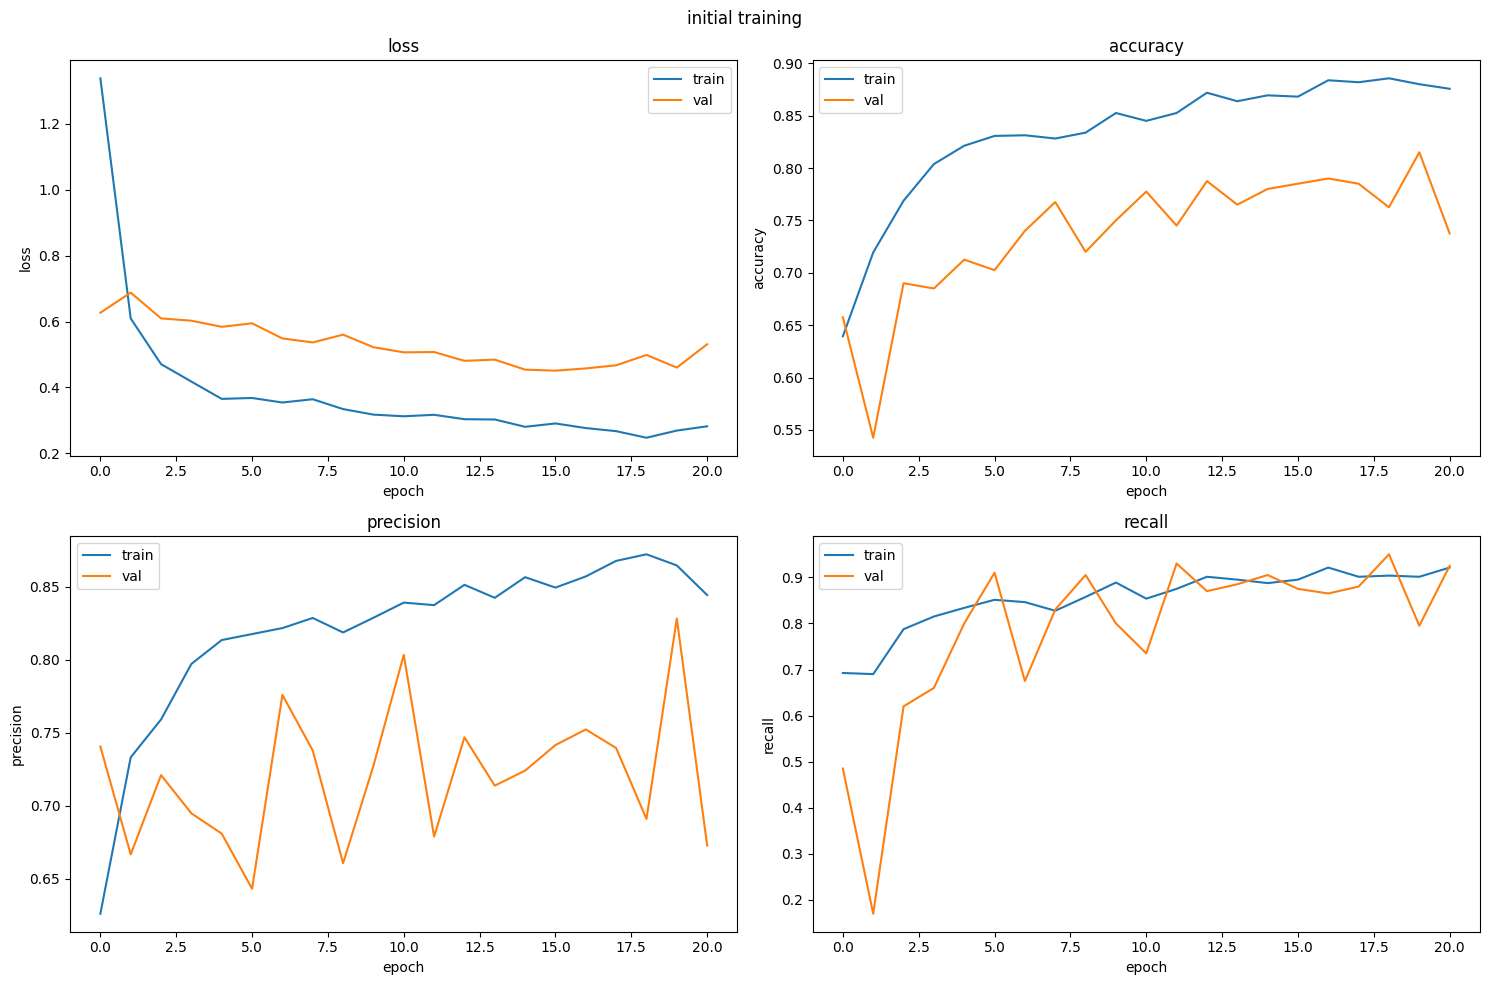

In [7]:
# train initial model
print("\ntraining initial model")
history = train_model(model, train_data_gen, val_data_gen)
plot_training_history(history, "initial training")

In [8]:
model_save_path = "../models/initial_resnet_model.keras"
print(f"\nsaving final model to {model_save_path}")
model.save(model_save_path)


saving final model to ../models/initial_resnet_model.keras


In [9]:
# hyperparams
batch_sizes = [16, 32, 64]
learning_rates = [0.001, 0.0001, 0.00001]
dropout_rates = [0.2, 0.3, 0.4]

# param grid
param_grid = list(itertools.product(batch_sizes, learning_rates, dropout_rates))

# define number of combinations to randomly sample
num_combinations_to_test = 5

# randomly sample combinations
sampled_params = random.sample(param_grid, num_combinations_to_test)
print(
    f"randomly sampling {num_combinations_to_test} combinations from {len(param_grid)} total."
)

randomly sampling 5 combinations from 27 total.


In [10]:
# hyperparameter tuning
print("\nperforming hyperparameter tuning")

results = []

for batch_size, learning_rate, dropout_rate in sampled_params:
    print(
        f"training with batch_size={batch_size}, learning_rate={learning_rate}, dropout_rate={dropout_rate}"
    )

    # update batch size in generators
    train_data_gen.batch_size = batch_size
    val_data_gen.batch_size = batch_size

    # build and train model
    model = build_transfer_model(input_shape, dropout_rate=dropout_rate)
    history = train_model(
        model, train_data_gen, val_data_gen, learning_rate=learning_rate
    )

    # get best validation metrics
    best_val_loss = min(history.history["val_loss"])
    best_val_acc = max(history.history["val_accuracy"])
    best_val_precision = max(history.history["val_precision"])
    best_val_recall = max(history.history["val_recall"])

    results.append(
        {
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "dropout_rate": dropout_rate,
            "val_loss": best_val_loss,
            "val_accuracy": best_val_acc,
            "val_precision": best_val_precision,
            "val_recall": best_val_recall,
        }
    )

# save results to csv
os.makedirs("../results", exist_ok=True)
results_df = pd.DataFrame(results)
results_df.to_csv("../results/transfer_learning_hyperparameter_tuning.csv", index=False)
print("\nhyperparameter tuning results:")
print(results_df)


performing hyperparameter tuning
training with batch_size=64, learning_rate=1e-05, dropout_rate=0.2
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6027 - loss: 0.9223 - precision: 0.5941 - recall: 0.6153 - val_accuracy: 0.5900 - val_loss: 0.7056 - val_precision: 0.5526 - val_recall: 0.9450
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6149 - loss: 0.7549 - precision: 0.6052 - recall: 0.7115 - val_accuracy: 0.6725 - val_loss: 0.6292 - val_precision: 0.6342 - val_recall: 0.8150
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6776 - loss: 0.6617 - precision: 0.6797 - recall: 0.6827 - val_accuracy: 0.7000 - val_loss: 0.6072 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7293 - loss: 0.5873 - precision: 0.7330 - recall: 0.7266 - val_accuracy: 0.7025 - val_loss: 0.5994 - val_precision: 0.6653 - val_recall: 0.8150
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.744

In [11]:
# concatenate train and val data
X_all = []
y_all = []

train_data_gen.reset()
val_data_gen.reset()

for batch_x, batch_y in train_data_gen:
    X_all.append(batch_x)
    y_all.append(batch_y)
    if len(X_all) * BATCH_SIZE >= train_data_gen.samples:
        break

for batch_x, batch_y in val_data_gen:
    X_all.append(batch_x)
    y_all.append(batch_y)
    if len(X_all) * BATCH_SIZE >= val_data_gen.samples + train_data_gen.samples:
        break

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)

# create dataset
train_val_ds = (
    tf.data.Dataset.from_tensor_slices((X_all, y_all))
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [12]:
def plot_training_history(history, title):
    """
    plot training and validation metrics

    params
    ------
    history: tf.keras.callbacks.History
        training history
    title: str
        plot title
    """
    metrics = ["loss", "accuracy", "precision", "recall"]
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        axes[idx].plot(history.history[metric], label="train")
        if f"val_{metric}" in history.history:
            axes[idx].plot(history.history[f"val_{metric}"], label="val")
        axes[idx].set_title(f"{metric}")
        axes[idx].set_xlabel("epoch")
        axes[idx].set_ylabel(metric)
        axes[idx].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


best hyperparameters: batch_size       32.000000
learning_rate     0.000100
dropout_rate      0.300000
val_loss          0.394171
val_accuracy      0.837500
val_precision     0.860759
val_recall        0.945000
Name: 3, dtype: float64

training final model
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 630ms/step - accuracy: 0.7215 - loss: 0.6307 - precision: 0.7051 - recall: 0.7656
Epoch 2/30


/opt/anaconda3/envs/ml-2025/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision,recall
  current = self.get_monitor_value(logs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 627ms/step - accuracy: 0.7969 - loss: 0.4319 - precision: 0.7876 - recall: 0.8019
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 631ms/step - accuracy: 0.8249 - loss: 0.3747 - precision: 0.8072 - recall: 0.8516
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 637ms/step - accuracy: 0.8620 - loss: 0.3078 - precision: 0.8543 - recall: 0.8737
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 638ms/step - accuracy: 0.8763 - loss: 0.2925 - precision: 0.8595 - recall: 0.9029
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 636ms/step - accuracy: 0.8843 - loss: 0.2646 - precision: 0.8702 - recall: 0.9010
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 635ms/step - accuracy: 0.8959 - loss: 0.2510 - precision: 0.8892 - recall: 0.9023
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 634ms/step - accuracy: 0.9099 - loss: 0.2229 - precision: 0.8977 - recall: 0.9269
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 636ms/step - accuracy: 0.9079 - loss: 0.2067 - precision: 0.8885 - recall: 0.9295
Epo

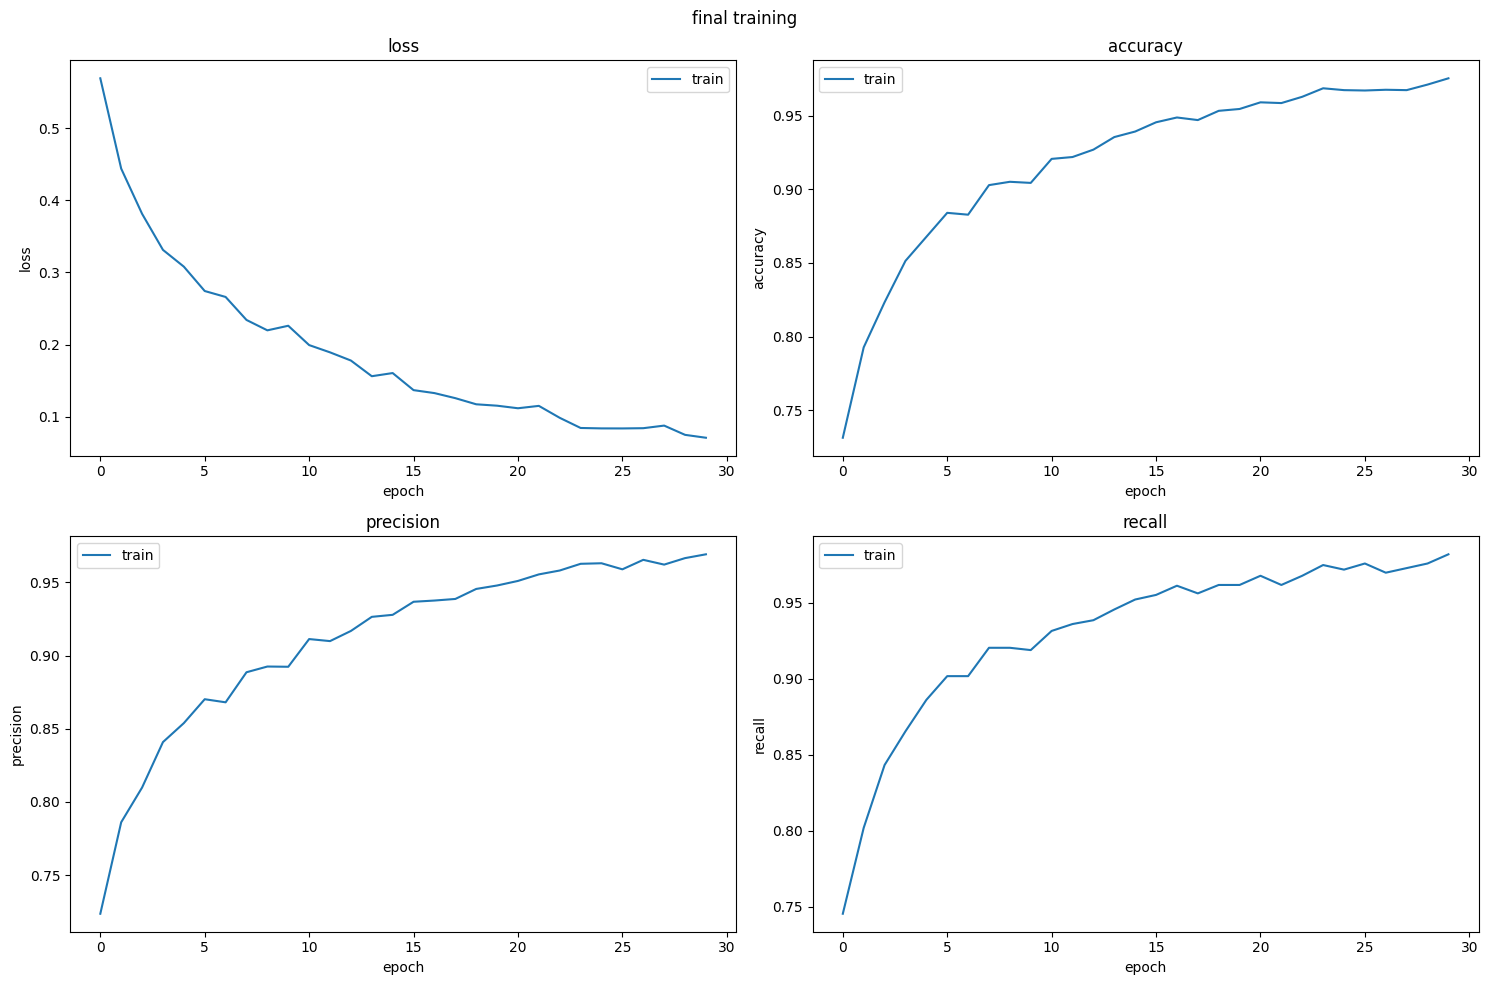


saving final model to ../models/final_resnet_model.keras


In [13]:
# train final model with best hyperparameters
best_params = results_df.loc[results_df["val_loss"].idxmin()]
print(f"\nbest hyperparameters: {best_params}")

# update batch size
train_data_gen.batch_size = int(best_params["batch_size"])
val_data_gen.batch_size = int(best_params["batch_size"])

# build and train model
print("\ntraining final model")
model = build_transfer_model(input_shape, dropout_rate=best_params["dropout_rate"])
history = train_model(
    model, train_val_ds, None, learning_rate=best_params["learning_rate"]
)
plot_training_history(history, "final training")

# save final model
model_save_path = "../models/final_resnet_model.keras"
print(f"\nsaving final model to {model_save_path}")
model.save(model_save_path)


fine-tuning
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 835ms/step - accuracy: 0.9661 - loss: 0.2402 - precision: 0.9597 - recall: 0.9730 - val_accuracy: 1.0000 - val_loss: 0.0180 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 814ms/step - accuracy: 0.9169 - loss: 0.2435 - precision: 0.9043 - recall: 0.9250 - val_accuracy: 1.0000 - val_loss: 0.0206 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 815ms/step - accuracy: 0.9153 - loss: 0.2247 - precision: 0.9120 - recall: 0.9224 - val_accuracy: 1.0000 - val_loss: 0.0260 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 823ms/step - accuracy: 0.9041 - loss: 0.2531 - precision: 0.9057 - recall: 0.9015 - val_accuracy: 1.0000 - val_loss: 0.0278 - val_precision: 1.0000 - val_recall: 1.0000


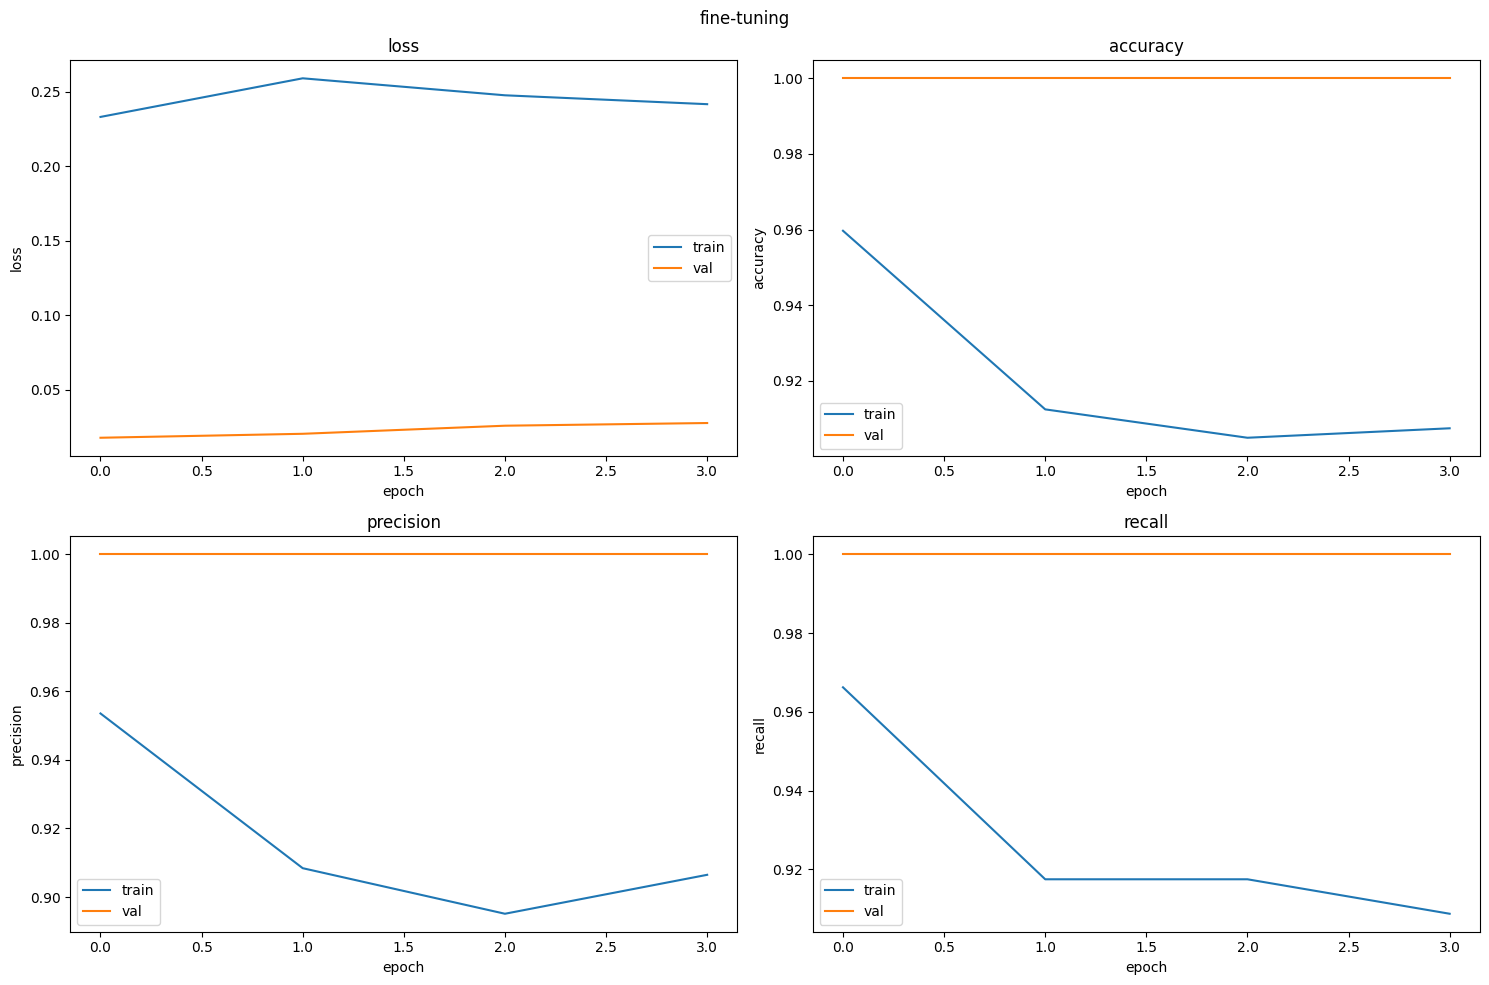


saving fine-tuned model to ../models/fine_tuned_resnet_model.keras


In [14]:
# fine-tune model
print("\nfine-tuning")
history_fine = fine_tune_model(model, train_data_gen, val_data_gen)
plot_training_history(history_fine, "fine-tuning")

# save fine-tuned model
model_save_path = "../models/fine_tuned_resnet_model.keras"
print(f"\nsaving fine-tuned model to {model_save_path}")
model.save(model_save_path)

In [15]:
# evaluate on test set
print("\nevaluating on test set")
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_data_gen)
print(f"test loss: {test_loss:.4f}")
print(f"test accuracy: {test_acc:.4f}")
print(f"test precision: {test_precision:.4f}")
print(f"test recall: {test_recall:.4f}")


evaluating on test set


/opt/anaconda3/envs/ml-2025/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8190 - loss: 0.5796 - precision: 0.7113 - recall: 0.8538
test loss: 0.5247
test accuracy: 0.8300
test precision: 0.8056
test recall: 0.8700



generating confusion matrix
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


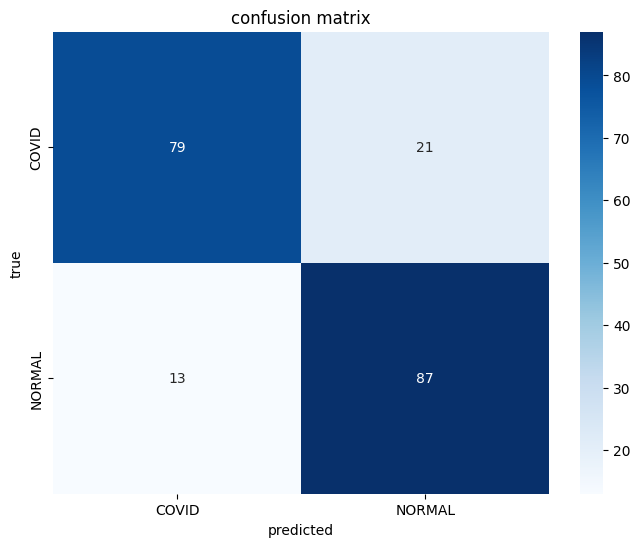

In [16]:
# plot confusion matrix
print("\ngenerating confusion matrix")
y_pred = model.predict(test_data_gen)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_data_gen.classes

plot_confusion_matrix(y_true, y_pred, class_names)


plotting sample predictions with raw images


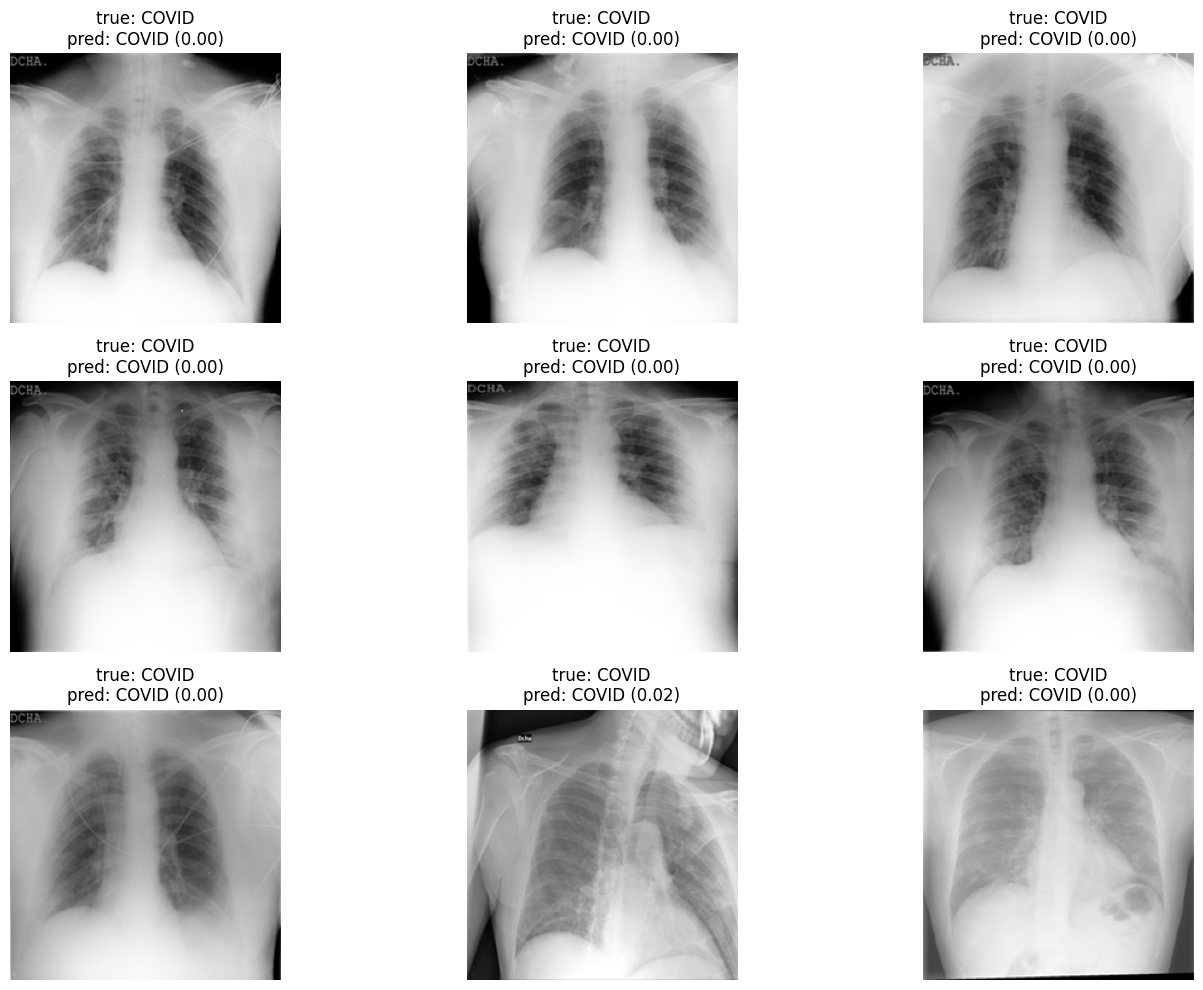

In [17]:
print("\nplotting sample predictions with raw images")

# get a batch of raw (unnormalized) images and labels
images_raw, labels_raw = next(iter(test_data_gen_raw))

# get the corresponding normalized batch for prediction
test_data_gen.reset()
images_norm, _ = next(iter(test_data_gen))

# make predictions
batch_pred_prob = model.predict(images_norm, verbose=0)
batch_pred = (batch_pred_prob > 0.5).astype(int).flatten()

# plot 9 samples
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_raw[i].astype("uint8"))
    true_class = class_names[int(labels_raw[i])]
    pred_class = class_names[batch_pred[i]]
    prob = batch_pred_prob[i][0]
    plt.title(f"true: {true_class}\npred: {pred_class} ({prob:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()